In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import pandas as pd
from itertools import combinations, permutations
%matplotlib inline

In [2]:
class Environment:
    def __init__(self,urn, groups, mius, noise, tao, rewards, residuals):
        self.urn=urn
        self.groups=groups
        self.mius=mius
        self.noise=noise
        self.tao=tao
        self.rewards=rewards
        self.residuals=residuals
    def total_groups(self):
        '''Retorna el número de grupos'''
        return(len(set(self.groups)))
    
    def total_neighborhoods(self):
        '''Retorna el total del barrios'''
        return(len(self.urn))
    
    def tot_urn(self):
        '''Retorna el total de crimenes en la urna'''
        return(sum(self.urn))
    
    def rate_neighborhood(self, i):
        '''Retorna la proporción de crímenes de un barrio en la urna'''
        return(self.urn[i]/self.tot_urn())
    
    def reward_neighborhood(self, i):
        
        return(self.rewards[i])
    
    def mius_n(self):
        '''Retorna la lista de tasas de barrios, determinado por el grupo de cada uno'''
        mius=[]
        for i in range(self.total_neighborhoods()):
            mius.append(self.mius[self.groups[i]])
        return mius
    
    def noise_n(self):
        '''Retorna la lista de ruidos de barrios, determinado por el grupo de cada uno'''
        sigmas=[]
        for i in range(self.total_neighborhoods()):
            sigmas.append(self.noise[self.groups[i]])
        return sigmas       

In [3]:
def outcome_likelihood(environment, neighborhoods):

    possibilities=list(permutations(list(range(environment.total_neighborhoods())), environment.tao))
    numerator=list(permutations(neighborhoods, environment.tao))
    
    return len(numerator)/len(possibilities)



In [40]:
def simulate_period(environment):
    
    
    #Crear el crimen y ruido de cada barrio.
    
    crime_n=[np.random.normal(loc=environment.mius[i], scale=environment.noise[i]) for i in range(environment.total_neighborhoods())]
    
    for i in crime_n:
        if i<0:       
            i=0
    
    
    # Se escoje a donde mandar Patrulleros dados los recursos
    likelihoods=[environment.rate_neighborhood(i) for i in range(environment.total_neighborhoods())]
    neighborhoods=list(np.random.choice(a=range(environment.total_neighborhoods()), p=likelihoods, 
                                   size=environment.tao, replace=False))
    
    # Se envían y añaden los crimenes del barrio donde vio. Además, se actualizan rewards.
    for i in neighborhoods:
        environment.urn[i]+=crime_n[i]
        environment.rewards[i]+=crime_n[i]        
    
    # Se envían añaden los crimenes a lo barrios de un mismo grupo observado.
    



    for i in range(environment.total_neighborhoods()):
        if neighborhoods.count(i)==0:
            #interpolation=sum([crime_n[j]*environment.groups[i,j] for j in neighborhoods])/sum([environment.groups[i,j] for j in neighborhoods])
            interpolation=sum([crime_n[j]*environment.groups[i,j] for j in neighborhoods])/environment.total_neighborhoods()
            environment.urn[i]+=interpolation

    # Se actualizan residuales
    for i in range(environment.total_neighborhoods()):
        if i not in neighborhoods:
            environment.residuals[i]+=crime_n[i]

    return(environment)  

In [41]:
def simulate_n_periods(environment, n, verbose=False):
    
    history_rewards=[environment.rewards.copy()]
    history_residuals=[environment.residuals.copy()]
    history_urn=[environment.urn.copy()]
    rates=[environment.rate_neighborhood(i) for i in range(environment.total_neighborhoods())]
    history_rate_urn=[rates]
    
    for i in range(n):
        if verbose and i%100==0:
            print(i)
        
        simulate_period(environment)
        history_rewards.append(environment.rewards.copy())
        history_residuals.append(environment.residuals.copy())
        history_urn.append(environment.urn.copy())
        rates=[environment.rate_neighborhood(i) for i in range(environment.total_neighborhoods())]
        history_rate_urn.append(rates)
        
    return environment, history_rate_urn, history_urn, history_rewards, history_residuals

In [42]:
def similarities(mius):
    
    sim=[]
    for i in range(len(mius)):
        sim.append([])
        for j in range(len(mius)):
            if j!=i:
                distance=abs(mius[i]-mius[j])/max([mius[j], mius[i]])
            else:
                distance=1
            sim[i].append(distance)
        
        sim[i]=[1-(k/max(sim[i])) for k in sim[i]]
    return np.array(sim)
        

In [43]:
number_neighborhoods=4
urn=[10,80,20,5]
sim=similarities(urn)
world=Environment(urn=urn, groups=sim, mius=[2,3,4,5], noise=[0]*number_neighborhoods,tao=2, 
                  rewards=[0]*number_neighborhoods, residuals=[0]*number_neighborhoods)

In [44]:
world,history_rate_urn, history_urn, history_rewards, history_residuals=simulate_n_periods(world, 10000, verbose=False)

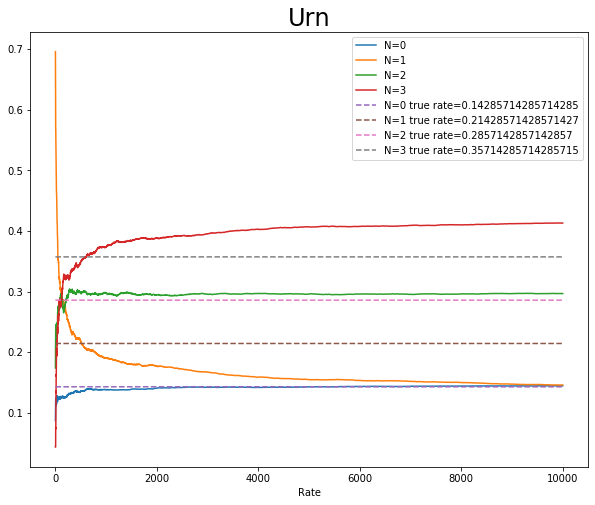

In [45]:
x_size=(len(history_rate_urn))

plt.figure(figsize=(10,8))
plt.title('Urn', fontsize=24)
for i in range(number_neighborhoods):
    plt.plot([j[i] for j in history_rate_urn], label='N='+str(i))
for i in range(len(True_rates)):
    plt.plot([True_rates[i]]*x_size, label='N='+str(i)+' true rate='+str(True_rates[i]), ls='--')
plt.xlabel('Period')
plt.xlabel('Rate')
plt.legend()

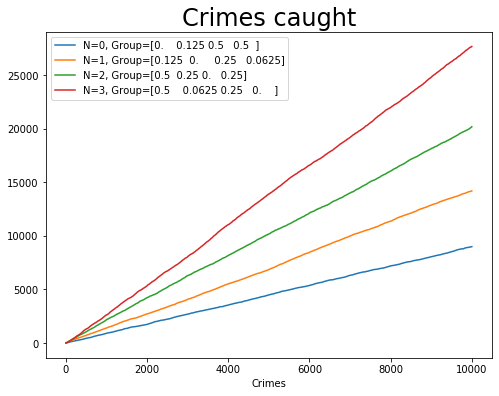

In [77]:
plt.figure(figsize=(8,6))
plt.title('Crimes caught', fontsize=24)
for i in range(number_neighborhoods):
    plt.plot([j[i] for j in history_rewards], label='N='+str(i)+', Group='+str(world.groups[i]))
plt.xlabel('Period')
plt.xlabel('Crimes')
plt.legend()

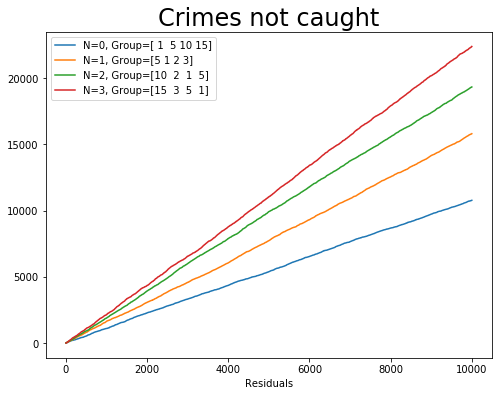

In [106]:
plt.figure(figsize=(8,6))
plt.title('Crimes not caught', fontsize=24)
for i in range(number_neighborhoods):
    plt.plot([j[i] for j in history_residuals], label='N='+str(i)+', Group='+str(world.groups[i]))
plt.xlabel('Period')
plt.xlabel('Residuals')
plt.legend()

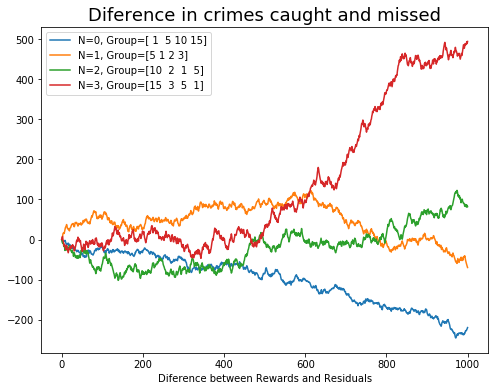

In [100]:
plt.figure(figsize=(8,6))
plt.title('Diference in crimes caught and missed', fontsize=18)
for i in range(number_neighborhoods):
    plt.plot([history_rewards[j][i]-history_residuals[j][i] for j in range(len(history_rewards))], 
             label='N='+str(i)+', Group='+str(world.groups[i]))
plt.xlabel('Period')
plt.xlabel('Diference between Rewards and Residuals')
plt.legend()

In [107]:
import math

Type:        module
String form: <module 'math' (built-in)>
Docstring:  
This module provides access to the mathematical functions
defined by the C standard.
